In [55]:
import os
import numpy as np
import torch
from PIL import Image
import xml.etree.ElementTree as ET
import torchvision.transforms as transforms

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.xml_files = [file for file in os.listdir(root) if file.endswith('.xml')]

    def parse_bbox(self, annotation_file):
        tree = ET.parse(annotation_file)
        root = tree.getroot()
        bboxes = []
        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text)
            ymin = int(bbox.find("ymin").text)
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            bboxes.append([xmin, ymin, xmax, ymax])
        return bboxes

    def __getitem__(self, idx):
        xml_file = os.path.join(self.root, self.xml_files[idx])
        img_file = os.path.splitext(xml_file)[0] + '.png'

        img = Image.open(img_file).convert("RGB")
        bboxes = self.parse_bbox(xml_file)

        if self.transforms is not None:
            img_np = np.array(img)
            transformed = self.transforms(image=img_np, bboxes=bboxes, labels=[1]*len(bboxes))
            img = transformed['image']
            bboxes = transformed['bboxes']

        num_objs = len(bboxes)
        boxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return img, target

    def __len__(self):
        return len(self.xml_files)


# 예시 사용법
root_dir = "/mnt/a/doordata"  # dataset의 루트 디렉토리

import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_augmentation(data_type):
    '''
    A simple augmentation function
    '''
    if data_type == 'train':
        return A.Compose(
            [
                A.Resize(300, 400),  # 이미지와 bounding box를 함께 resize합니다.
                A.HorizontalFlip(),
                A.VerticalFlip(),
                ToTensorV2()
            ],
            bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
        )

dataset = CustomDataset(root_dir, get_augmentation('train'))
img, target = dataset[0]  # 첫 번째 데이터 샘플
print("Image size:", img.size())
print("Number of objects:", len(target["boxes"]))


Image size: torch.Size([3, 300, 400])
Number of objects: 5


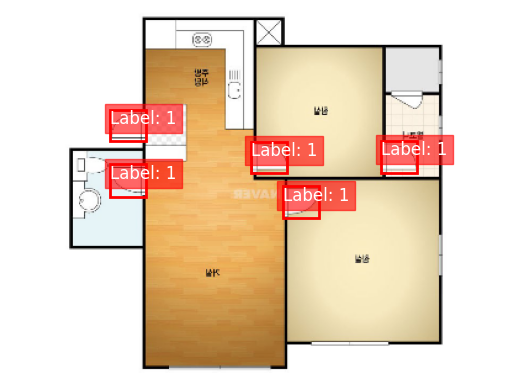

In [56]:
import matplotlib.pyplot as plt

def visualize_bbox(img, target):
    img = np.array(img)
    img = np.transpose(img, (1, 2, 0))  # 이미지의 차원 순서를 (H, W, C)로 변경합니다.
    boxes = target["boxes"].numpy().astype(np.int32)
    labels = target["labels"].numpy()

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        label = labels[i]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="red", linewidth=2)
        ax.add_patch(rect)
        ax.text(xmin, ymin, f"Label: {label}", fontsize=12, color="white", verticalalignment="top",
                bbox={"color": "red", "alpha": 0.6})
    
    plt.axis("off")
    plt.show()

# 예시 사용법
visualize_bbox(img, target)


In [57]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 2  # 1 클래스(사람) + 배경
# 분류기에서 사용할 입력 특징의 차원 정보를 얻습니다
in_features = model.roi_heads.box_predictor.cls_score.in_features
# 미리 학습된 모델의 머리 부분을 새로운 것으로 교체합니다
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [58]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# 분류 목적으로 미리 학습된 모델을 로드하고 특징들만을 리턴하도록 합니다
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# Faster RCNN은 백본의 출력 채널 수를 알아야 합니다.
# mobilenetV2의 경우 1280이므로 여기에 추가해야 합니다.
backbone.out_channels = 1280

# RPN(Region Proposal Network)이 5개의 서로 다른 크기와 3개의 다른 측면 비율(Aspect ratio)을 가진
# 5 x 3개의 앵커를 공간 위치마다 생성하도록 합니다.
# 각 특징 맵이 잠재적으로 다른 사이즈와 측면 비율을 가질 수 있기 때문에 Tuple[Tuple[int]] 타입을 가지도록 합니다.

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# 관심 영역의 자르기 및 재할당 후 자르기 크기를 수행하는 데 사용할 피쳐 맵을 정의합니다.
# 만약 백본이 텐서를 리턴할때, featmap_names 는 [0] 이 될 것이라고 예상합니다.
# 일반적으로 백본은 OrderedDict[Tensor] 타입을 리턴해야 합니다.
# 그리고 특징맵에서 사용할 featmap_names 값을 정할 수 있습니다.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# 조각들을 Faster RCNN 모델로 합칩니다.
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [59]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = CustomDataset(root_dir, get_augmentation('train'))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4)
# 학습 시
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# 추론 시
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/root/miniconda3/envs/room_seg/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/root/miniconda3/envs/room_seg/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/root/miniconda3/envs/room_seg/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/root/miniconda3/envs/room_seg/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 142, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/root/miniconda3/envs/room_seg/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 142, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/root/miniconda3/envs/room_seg/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 127, in collate
    return elem_type({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/root/miniconda3/envs/room_seg/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 127, in <dictcomp>
    return elem_type({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/root/miniconda3/envs/room_seg/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/root/miniconda3/envs/room_seg/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py", line 161, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable
